In [1]:
!pip install sunriset

  Using cached sunriset-1.0-py3-none-any.whl (9.6 kB)
You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import datacube
from datacube.utils import geometry

import geopandas as gpd
import pandas as pd
import xarray as xr

import sunriset ##(will need to `pip install sunriset` on first loading)
from otps import TimePoint
from otps import predict_tide
import pytz
import math
import datetime
from datetime import timedelta

import sys
sys.path.append("../Scripts")
from dea_plotting import map_shapefile
from dea_dask import create_local_dask_cluster

# solar modelling modules
# import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
dc = datacube.Datacube(app="intertidal_exposure")
create_local_dask_cluster()

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Client Scheduler: tcp://127.0.0.1:40843 Dashboard: /user/cp/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 125.85 GB


In [5]:
## Set variables 

# Read in the polygon vector file
%cd '/home/jovyan/dev/dea-notebooks/Claire/'
vector_file = "ITEMv2_tidalmodel.shp"
attribute_col = "ID"
gdf_master = gpd.read_file(vector_file)

# ## Index by date. This may break when time_start or time_end do not appear in the filtered dataset
## Ideally: 18.61 year window (19 years), the global average astronomically forced lunar nodal cycle (e.g. Haigh et al., 2011)
## NOTE: tidal and exposure modelling are set from the `time_start` and `time_end` parameters
time_start = '2019-12-01 00:00:00'
time_end = '2020-12-01 00:00:00'

## Set the frequency to run the tidal modelling
modelled_freq='10min'

# ## Set the filter to apply for the exposure modelling
# time_filter = 'Oct'

query = {
    'product': ['nidem'],
    "dask_chunks": {"time": 1, "x": 1000, "y": 1000}
        }

/home/jovyan/dev/dea-notebooks/Claire


In [6]:
#### TEST CELL!
### Incorporate solar exposure (sunrise/set) and rebuild the datetime filter to generate 
### all required values simultaneously

# ##### Build a list of DataArrays to concat



def exp_model(time_start, time_end, time_filter, modelled_freq, tidepost_lat, tidepost_lon):#, round_stats):
    
    '''
    For each modelled timestep in modelledtides,
    mask NIDEM for the associated tideheight.
    Save the lists of timesteps and masked arrays
    and concatenate to join all arrays on the new
    dimension 'datetime'
    
    Time filtering (`time_filter`) options for exposure mapping routine are:
    all_time,
    day,
    night,
    wet,
    dry,
    summer,
    autumn,
    winter,
    spring,
    Jan,
    Feb,
    Mar,
    Apr,
    May,
    Jun,
    Jul,
    Aug,
    Sep,
    Oct,
    Nov,
    Dec
    
    Use one of the following strings to match your tidepost to set the appropriate `timezone`
    UTC       =  pytz.UTC ## Coordinated Universal Time
    UTC + 8   = 'Australia/West'

    UTC + 9.5 = 'Australia/North'
                'Australia/South'

    UTC + 10  = 'Australia/Queensland'
                'Australia/NSW'
                'Australia/Victoria'
                'Australia/Tasmania'
    '''
    '''------------------------------------'''
    ## Run tidal modelling

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=time_start,
                                  end=time_end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]
        ## Save modelled tides as dataframe
        ## Firstly convert the dates to series
    all_timerange = all_timerange.to_series()
        ## Save dates and tideheights to pd.DataFrame
    modelledtides = pd.DataFrame(data={'timerange': all_timerange,
                       'tideheights': all_tideheights})

    '''---------------------------------------------------------'''
    ## Automate timezone selection based on location of tidepost
    ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
    if tidepost_lon <= 129.0:
        timezone = 'Australia/West'
        local_tz = 8
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/North'
        local_tz = 9.5
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
        timezone = 'Australia/South'
        local_tz = 9.5
    elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/Queensland'
        local_tz = 10
    elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
        timezone = 'Australia/NSW'
        local_tz = 10
    else:
        print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
    print('Timezone set to', timezone)
    
    ## Convert time_start and time_end to datetime objects in local timezone
    time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
    time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
    ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
    localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

    ## Convert tz-aware index to local timezone
    localtides = localtides.tz_convert(timezone)
    
    ## Reset the index of modelledtides to reflect local times
    modelledtides['local_timerange'] = localtides
    modelledtides.set_index('local_timerange', inplace=True)
    modelledtides.drop('timerange', axis=1, inplace=True)
    
    '''---------------------------------'''
    ## Prepare data for use in solar modelling function (sunriset)
    ## Translate input dates to datetime
    format = '%Y-%m-%d %H:%M:%S'
    start = pd.to_datetime(time_start, format=format)
    end = pd.to_datetime(time_end, format=format)

    ## Calculate number of days between input dates
    diff = end-start

    ## Return difference in years
    yearsdiff = diff.days/365

    ## Round up to ensure all modelledtide datetimes are captured in solar model
    yearsdiff = int(math.ceil(yearsdiff))

    ## Identify variables for solar model input
    lat = tidepost_lat ## from tidepost
    long = tidepost_lon ## from tidepost
#     local_tz = local_tz  ## hardcoded for 3 Austral regions

    number_of_years = yearsdiff
    start_date = datetime.date(start.year, start.month, start.day) ## from query

    ## Model sunrise and sunset
    sun_df = sunriset.to_pandas(start_date, lat, long, local_tz, number_of_years)

    ## Return sunrise/sunset in hh:mm:ss format (str)
    sun_df['Sunrise hh:mm:ss'] = sun_df['Sunrise'].apply(
            lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))
    sun_df['Sunset hh:mm:ss'] = sun_df['Sunset'].apply(
            lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))

    ## Drop accessory columns
    sun_df = sun_df[['Sunrise hh:mm:ss','Sunset hh:mm:ss']]

    ## Set the index as a datetimeindex to match the modelledtide df
    sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))
    
    return sun_df, localtides, modelledtides
    '''--------------------------------------'''
#     ## Create all required time filters
    
#     ## Create dict to store filtered times
#     filters = {}
#     ## Create a filteredtides dataframe for the filters of interest
#     for x in time_filter:
        
#         if x == 'all_time':
#             filteredtides = modelledtides
#             filters[str(x)] = filteredtides
        
#         elif x == 'night':
#             night = localtides.drop(localtides[(localtides.hour == 6) ## Daylight: arbitrarily between 6 am and 5.59 pm
#                         |(localtides.hour == 7)
#                         |(localtides.hour == 8)
#                         |(localtides.hour == 9)
#                         |(localtides.hour == 10)
#                         |(localtides.hour == 11)
#                         |(localtides.hour == 12)
#                         |(localtides.hour == 13)
#                         |(localtides.hour == 14)
#                         |(localtides.hour == 15)
#                         |(localtides.hour == 16)
#                         |(localtides.hour == 17)
#                         ])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in night.array)
#             filteredtides['timerange'] = night
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'day':
#             day = localtides.drop(localtides[(localtides.hour == 0) ## Nighttime: arbitrarily between 6 pm and 5.59 am
#                         |(localtides.hour == 1)
#                         |(localtides.hour == 2)
#                         |(localtides.hour == 3)
#                         |(localtides.hour == 4)
#                         |(localtides.hour == 5)
#                         |(localtides.hour == 18)
#                         |(localtides.hour == 19)
#                         |(localtides.hour == 20)
#                         |(localtides.hour == 21)
#                         |(localtides.hour == 22)
#                         |(localtides.hour == 23)
#                         ])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in day.array)
#             filteredtides['timerange'] = day
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'dry':
#             dry = localtides.drop(localtides[(localtides.month == 10) ## Wet season: Oct-Mar
#                         |(localtides.month == 11)
#                         |(localtides.month == 12)
#                         |(localtides.month == 1)
#                         |(localtides.month == 2)
#                         |(localtides.month == 3)
#                         ])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in dry.array)
#             filteredtides['timerange'] = dry
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'wet':
#             wet = localtides.drop(localtides[(localtides.month == 4) ## Dry season: Apr-Sep
#                         |(localtides.month == 5)
#                         |(localtides.month == 6)
#                         |(localtides.month == 7)
#                         |(localtides.month == 8)
#                         |(localtides.month == 9)
#                         ])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in wet.array)
#             filteredtides['timerange'] = wet
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'summer':
#             summer = localtides.drop(localtides[localtides.quarter != 1])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in summer.array)
#             filteredtides['timerange'] = summer
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'autumn':
#             autumn = localtides.drop(localtides[localtides.quarter != 2])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in autumn.array)
#             filteredtides['timerange'] = autumn
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'winter':
#             autumn = localtides.drop(localtides[localtides.quarter != 3])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in winter.array)
#             filteredtides['timerange'] = winter
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'spring':
#             spring = localtides.drop(localtides[localtides.quarter != 4])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in spring.array)
#             filteredtides['timerange'] = spring
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Jan':
#             Jan = localtides.drop(localtides[localtides.month != 1])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jan.array)
#             filteredtides['timerange'] = Jan
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Feb':
#             Feb = localtides.drop(localtides[localtides.month != 2])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Feb.array)
#             filteredtides['timerange'] = Feb
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Mar':
#             Mar = localtides.drop(localtides[localtides.month != 3])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Mar.array)
#             filteredtides['timerange'] = Mar
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Apr':
#             Apr = localtides.drop(localtides[localtides.month != 4])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Apr.array)
#             filteredtides['timerange'] = Apr
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'May':
#             May = localtides.drop(localtides[localtides.month != 5])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in May.array)
#             filteredtides['timerange'] = May
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Jun':
#             Jun = localtides.drop(localtides[localtides.month != 6])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jun.array)
#             filteredtides['timerange'] = Jun
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Jul':
#             Jul = localtides.drop(localtides[localtides.month != 7])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jul.array)
#             filteredtides['timerange'] = Jul
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Aug':
#             Aug = localtides.drop(localtides[localtides.month != 8])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Aug.array)
#             filteredtides['timerange'] = Aug
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Sep':
#             Sep = localtides.drop(localtides[localtides.month != 9])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Sep.array)
#             filteredtides['timerange'] = Sep
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Oct':
#             Oct = localtides.drop(localtides[localtides.month != 10])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Oct.array)
#             filteredtides['timerange'] = Oct
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Nov':
#             Nov = localtides.drop(localtides[localtides.month != 11])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Nov.array)
#             filteredtides['timerange'] = Nov
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Dec':
#             Dec = localtides.drop(localtides[localtides.month != 12])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Dec.array)
#             filteredtides['timerange'] = Dec
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         else:
#             print('''
#             Please select one of the following `time_filter`s: 
#             all_time, day, night, wet, dry, summer, autumn, winter, 
#             spring, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
#             ''')
    
#     ## Create wet/dry boolean for each timestep per filter
#     WetDry = {}
#     for key in filters:
                
#         ## Boolean mask all modelled timesteps by tideheight relative to NIDEM:
#         da_list = list(ds.nidem >= filters[str(key)]['tideheights'][timestep] 
#                        for timestep in filters[str(key)].loc[time_start:time_end].index) 

#         index_list = list(timestep for timestep in filters[str(key)][time_start:time_end].index)

#         ## Store modelled datetimes as a pandas index
#         index = pd.Index(index_list, name='datetime')

#         ## Concatenate the arrays on the new dimension 'datetime'
#         exp_ds = xr.concat(da_list, index)
        
#         WetDry[str(key)] = exp_ds
#     '''--------------------------------------------'''
#     ## Calculate the pc exposure per pixel for each filter
#     ## Build empty xr.ds and append each new da during looping through WetDry
    
#     pxpc2 = ds#.squeeze().reset_coords() ## Copy of NIDEM ds to append exposure results into
    
#     for f in WetDry:
    
#             ## Calculate the mean of the boolean across the datetime axis (equiv. to % True)
#         pxpc = WetDry[str(f)].mean('datetime')

#         ## Compute the array from dask
# #         pxpc = pxpc.compute() #%timeit

#         ## Name the exposure time array
#         pxpc = pxpc.rename('Exposure time (%)')

#         ## Mask out non-intertidal areas
#         pxpc = pxpc.where(pxpc > 0)
        
#         ## Append filter (f) exposure results into results dataset (pxpc2)
#         pxpc2[str(f)] = pxpc#.drop('time')

# #         ## Save exposure results
# #         pxpc.drop('time').to_netcdf("ID"
# #                        + str(row.ID)
# #                        + "_tidepost_"
# #                        + str(tp_y) 
# #                        + '_'
# #                        + str(tp_x) 
# #                        + "_pxpc_for_modelledtides20min_" 
# #                        + str(time_start)
# #                        + '_to_'
# #                        + str(time_end)
# #                        + "time_filter_"
# #                        + str(time_filter)
# #                        + ".nc")
# #         # ## To save the NIDEM dataset to netcdf, need to remove the time dimension
# #         ds = ds.squeeze()
# #         ds = ds.reset_coords()
# #         ds.nidem.to_netcdf("ID" + str(row.ID) +"_tidepost_"+str(tp_y) + '_'+ str(tp_x) +'nidem.nc') 
#     pxpc2 = pxpc2.compute()    
    
#     return pxpc2#exp_ds


# # # ## TEMP: refresh the modelledtides var
# # # modelledtides = pd.read_pickle("tidepost_"+str(tp_y) + '_'+ str(tp_x) + "_modelledtides_20min.pkl")

# # ## Run function to collect exposure dataset. Set time filter to one of the following:
# # '''all_time,
# #     day,
# #     night,
# #     wet, # wet_season
# #     dry, # dry_season
# #     summer,
# #     autumn,
# #     winter,
# #     spring,
# #     Jan,
# #     Feb,
# #     Mar,
# #     Apr,
# #     May,
# #     Jun,
# #     Jul,
# #     Aug,
# #     Sep,
# #     Oct,
# #     Nov,
# #     Dec'''

In [8]:
## Test cell: incoporating solar modelling and reworking time/date filtering

## Prototyping the continental workflow
time_filter = ['Jan', 'Feb']
## Prepare dict to store results
ITEMpolygons = {}
# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf_master.iterrows():

    # Extract the feature's geometry as a datacube geometry object
    geom = geometry.Geometry(geom=row.geometry, crs=gdf_master.crs)

    # Update the query to include our geopolygon
    query.update({"geopolygon": geom})

    ds = dc.load(**query)
    ds = ds.where(ds.nidem > ds.nidem.min())
    
    '''-------------------'''
    ## Run the exp_model function to generate tide model and exposure dataset
#     pxpc2 = exp_model(time_start, 
#                        time_end,                        
#                        time_filter,
#                        modelled_freq,
#                        tidepost_lat = row.lat, 
#                        tidepost_lon = row.lon)

    sun_df, localtides, modelledtides = exp_model(time_start, 
                       time_end,                        
                       time_filter,
                       modelled_freq,
                       tidepost_lat = row.lat, 
                       tidepost_lon = row.lon)
    
    ## Save filtered, exposure results (pxpc2) per polyon in results dics
#     ITEMpolygons[str(index)] = pxpc2
    
    ## Stop looping
    if index == 0:
        break
    print('Completed polygon: ', index)

Timezone set to Australia/West


In [55]:
## Testing cell
# modelled_freq
print(sun_df.head())
print('''-----''')
print(localtides[0:100])

           Sunrise hh:mm:ss  Sunset hh:mm:ss
2019-12-01   5:15:48.494407  18:30:07.107169
2019-12-02   5:15:54.936700  18:30:45.701560
2019-12-03   5:16:02.692913  18:31:24.227265
2019-12-04   5:16:11.752682  18:32:02.648510
2019-12-05   5:16:22.104328  18:32:40.928990
-----
DatetimeIndex(['2019-12-01 08:00:00+08:00', '2019-12-01 08:10:00+08:00',
               '2019-12-01 08:20:00+08:00', '2019-12-01 08:30:00+08:00',
               '2019-12-01 08:40:00+08:00', '2019-12-01 08:50:00+08:00',
               '2019-12-01 09:00:00+08:00', '2019-12-01 09:10:00+08:00',
               '2019-12-01 09:20:00+08:00', '2019-12-01 09:30:00+08:00',
               '2019-12-01 09:40:00+08:00', '2019-12-01 09:50:00+08:00',
               '2019-12-01 10:00:00+08:00', '2019-12-01 10:10:00+08:00',
               '2019-12-01 10:20:00+08:00', '2019-12-01 10:30:00+08:00',
               '2019-12-01 10:40:00+08:00', '2019-12-01 10:50:00+08:00',
               '2019-12-01 11:00:00+08:00', '2019-12-01 11:10:00+08

In [57]:
# sun_df.index[0].date()
# # localtides[0]
# sun_df.index[2]
for date in sun_df.index[0:2]:
    print(date)

2019-12-01 00:00:00
2019-12-02 00:00:00


In [78]:
time_filter = ['day', 'night']
filters = {}

# x=0
# test=[]
## Create a filteredtides dataframe for the filters of interest
for x in time_filter:
    
#     for date in sun_df.index[0:1]:
#         for ldate in localtides:      
#             if (ldate.date() == date.date()):
#                 print(localtides.date(ldate))
# #                 rise = sun_df.loc[date]['Sunrise hh:mm:ss']
# #                 sset = sun_df.loc[date]['Sunset hh:mm:ss']
# #                 sun=localtides.loc[ldate].indexer_between_time(rise, sset, include_start=True, include_end=False)
    for date in sun_df.index[0:1]:
            for ldate in localtides:  
                for tstamp in (ldate.date() == date.date()):
                    print (tstamp)
#             if (ldate.date() == date.date()):
#                 print(localtides.date(ldate))
#                 rise = sun_df.loc[date]['Sunrise hh:mm:ss']
#                 sset = sun_df.loc[date]['Sunset hh:mm:ss']
#                 sun=loca
    
print(len(test))    
#     ## Stop looping
#     if date == pd.to_datetime('2019-12-01'):#.date():
#         break                
                
#          if sun_df.index[date].date() in localtides.date():
# #         if date in localtides.date():
#             print('True')#date)
    
#     if x == 'night':
#         night = localtides.drop(localtides[(localtides.hour == 6) ## Daylight: arbitrarily between 6 am and 5.59 pm
#                     |(localtides.hour == 7)
#                     |(localtides.hour == 8)
#                     |(localtides.hour == 9)
#                     |(localtides.hour == 10)
#                     |(localtides.hour == 11)
#                     |(localtides.hour == 12)
#                     |(localtides.hour == 13)
#                     |(localtides.hour == 14)
#                     |(localtides.hour == 15)
#                     |(localtides.hour == 16)
#                     |(localtides.hour == 17)
#                     ])

#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in night.array)
#         filteredtides['timerange'] = night
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#         filters[str(x)] = filteredtides

#     elif x == 'day':
#         day = localtides.drop(localtides[(localtides.hour == 0) ## Nighttime: arbitrarily between 6 pm and 5.59 am
#                     |(localtides.hour == 1)
#                     |(localtides.hour == 2)
#                     |(localtides.hour == 3)
#                     |(localtides.hour == 4)
#                     |(localtides.hour == 5)
#                     |(localtides.hour == 18)
#                     |(localtides.hour == 19)
#                     |(localtides.hour == 20)
#                     |(localtides.hour == 21)
#                     |(localtides.hour == 22)
#                     |(localtides.hour == 23)
#                     ])

TypeError: 'bool' object is not iterable

In [149]:

lt_df=pd.DataFrame(localtides, columns=['localtides'])

dates = []
times = []
for element in localtides:
    d = element.date()
    dates.append(d)
    
    t = element.time()
    times.append(t)

lt_df['Date'] = dates
lt_df['Time'] = times

lt_df.head()

# for date in sun_df.index[0:10]:
    
#     lt_df['Day'] = lt_df['localtides'].where(
#         ((lt_df['Time'].values() >= sun_df.loc[date]['Sunrise hh:mm:ss']) &
#         (lt_df['Time'].values() < sun_df.loc[date]['Sunset hh:mm:ss']))
#                                 )
# print(lt_df)    
#     print(date)
#     if lt_df.Date.isindate.date()
#     for date.date() in lt_df.Date:
#     if lt_df.Date.values.any() == date.date():
#         print ('True')

distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)


,localtides,Date,Time
0,2019-12-01 08:00:00+08:00,2019-12-01,08:00:00
1,2019-12-01 08:10:00+08:00,2019-12-01,08:10:00
2,2019-12-01 08:20:00+08:00,2019-12-01,08:20:00
3,2019-12-01 08:30:00+08:00,2019-12-01,08:30:00
4,2019-12-01 08:40:00+08:00,2019-12-01,08:40:00


In [95]:
# # type(localtides)#.date()
# for date in localtides:
#     print(type(date.date()))
# sun_df[0:1]
# localtides[0:10]

test = []
for val in localtides[0:1000]:
    if val.date() == pd.to_datetime('2019-12-01').date():
        test.append(val)
#     print(val.date())
print(test[0:10])

[Timestamp('2019-12-01 08:00:00+0800', tz='Australia/West', freq='10T'), Timestamp('2019-12-01 08:10:00+0800', tz='Australia/West', freq='10T'), Timestamp('2019-12-01 08:20:00+0800', tz='Australia/West', freq='10T'), Timestamp('2019-12-01 08:30:00+0800', tz='Australia/West', freq='10T'), Timestamp('2019-12-01 08:40:00+0800', tz='Australia/West', freq='10T'), Timestamp('2019-12-01 08:50:00+0800', tz='Australia/West', freq='10T'), Timestamp('2019-12-01 09:00:00+0800', tz='Australia/West', freq='10T'), Timestamp('2019-12-01 09:10:00+0800', tz='Australia/West', freq='10T'), Timestamp('2019-12-01 09:20:00+0800', tz='Australia/West', freq='10T'), Timestamp('2019-12-01 09:30:00+0800', tz='Australia/West', freq='10T')]


In [102]:
# test = localtides.where(localtides.date() == pd.to_datetime('2019-12-01').date())
localtides.isin([pd.to_datetime('2019-12-01').date()])#==localtides.isin([pd.to_datetime('2019-12-01')])

array([ True, False, False, ..., False, False, False])

In [107]:
# datetime.date('2019-12-01')
pd.to_datetime('2019-12-01')#.date()
localtides[0:2].isin([pd.to_datetime('2019-12-01')])
# test = localtides.where()

array([ True, False])

In [5]:
# ## Test cell
# import datetime
# start_date = datetime.date(2019,1,1)
# start_date

In [6]:
# ## Test cell
# datetime.date(s.year, s.month, s.day)
# # s.year

In [7]:
# ## Test cell: solar modelling

# ## Prepare data for use in solar modelling function (sunriset)

# ## Translate input dates to datetime
# format = '%Y-%m-%d %H:%M:%S'
# start = pd.to_datetime(time_start, format=format)
# end = pd.to_datetime(time_end, format=format)

# ## Calculate number of days between input dates
# diff = end-start

# ## Return difference in years
# yearsdiff = diff.days/365

# ## Round up to ensure all modelledtide datetimes are captured in solar model
# yearsdiff = int(math.ceil(yearsdiff))

# ## Identify variables for solar model input
# lat = 34.0522 ## from tidepost
# long = -118.2437 ## from tidepost
# local_tz = -8  ## hardcoded for 3 Austral regions

# number_of_years = yearsdiff
# start_date = datetime.date(start.year, start.month, start.day) ## from query

# ## Model sunrise and sunset
# sun_df = sunriset.to_pandas(start_date, lat, long, local_tz, number_of_years)

# ## Return sunrise/sunset in hh:mm:ss format (str)
# sun_df['Sunrise hh:mm:ss'] = sun_df['Sunrise'].apply(
#         lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))
# sun_df['Sunset hh:mm:ss'] = sun_df['Sunset'].apply(
#         lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))

# ## Drop accessory columns
# sun_df = sun_df[['Sunrise hh:mm:ss','Sunset hh:mm:ss']]

# ## Set the index as a datetimeindex to match the modelledtide df
# sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))
 
# # sun_df

In [16]:
# def tidal_stats(
#                 start=time_start,
#                 end=time_end,
#                 tidepost_lat=None,
#                 tidepost_lon=None,
#                 modelled_freq=modelled_freq,
#                 round_stats=3): 
#     """
#     Takes an xarray.Dataset and statistically compares the tides 
#     modelled for each satellite observation against the full modelled 
#     tidal range. This comparison can be used to evaluate whether the 
#     tides observed by satellites (e.g. Landsat) are biased compared to 
#     the natural tidal range (e.g. fail to observe either the highest or 
#     lowest tides etc).    
       
#     By default, the function models tides for the centroid of the 
#     dataset, but a custom tidal modelling location can be specified 
#     using `tidepost_lat` and `tidepost_lon`.
    
#     Tides are modelled using the OTPS tidal modelling software based on
#     the TPXO8 tidal model: http://volkov.oce.orst.edu/tides/tpxo8_atlas.html
    
#     For more information about the tidal statistics computed by this 
#     function, refer to Figure 8 in Bishop-Taylor et al. 2018:
#     https://www.sciencedirect.com/science/article/pii/S0272771418308783#fig8
    
#     Parameters
#     ----------     
#     ds : xarray.Dataset
#         An xarray.Dataset object with x, y and time dimensions  
#     tidepost_lat, tidepost_lon : float or int, optional
#         Optional coordinates used to model tides. The default is None,
#         which uses the centroid of the dataset as the tide modelling 
#         location.
#     plot : bool, optional
#         An optional boolean indicating whether to plot how satellite-
#         observed tide heights compare against the full tidal range. 
#         Defaults to True.
#     modelled_freq : str, optional
#         An optional string giving the frequency at which to model tides 
#         when computing the full modelled tidal range. Defaults to '2h', 
#         which computes a tide height for every two hours across the
#         temporal extent of `ds`.        
#     round_stats : int, optional
#         The number of decimal places used to round the output statistics.
#         Defaults to 3.
        
#     Returns
#     -------
#     TODO
    
#     """

#     # Generate range of times covering entire period of satellite record
#     all_timerange = pd.date_range(start=start,
#                                   end=end,
#                                   freq=modelled_freq)
#     all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

#     # Use the tidal model to compute tide heights for each observation:  
#     all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
#                       for dt in all_datetimes]
#     all_predictedtides = predict_tide(all_timepoints)   
#     all_tideheights = [predictedtide.tide_m for predictedtide 
#                         in all_predictedtides]

#     return all_timerange, all_tideheights

In [10]:
# # ##### Build a list of DataArrays to concat

# def exp_model(time_start, time_end, modelledtides, time_filter, tidepost_lat, tidepost_lon):
    
#     '''
#     For each modelled timestep in modelledtides,
#     mask NIDEM for the associated tideheight.
#     Save the lists of timesteps and masked arrays
#     and concatenate to join all arrays on the new
#     dimension 'datetime'
    
#     Time filtering (`time_filter`) options for exposure mapping routine are:
#     all_time,
#     day,
#     night,
#     wet,
#     dry,
#     summer,
#     autumn,
#     winter,
#     spring,
#     Jan,
#     Feb,
#     Mar,
#     Apr,
#     May,
#     Jun,
#     Jul,
#     Aug,
#     Sep,
#     Oct,
#     Nov,
#     Dec
    
#     Use one of the following strings to match your tidepost to set the appropriate `timezone`
#     UTC       =  pytz.UTC ## Coordinated Universal Time
#     UTC + 8   = 'Australia/West'

#     UTC + 9.5 = 'Australia/North'
#                 'Australia/South'

#     UTC + 10  = 'Australia/Queensland'
#                 'Australia/NSW'
#                 'Australia/Victoria'
#                 'Australia/Tasmania'
#     '''
#     ## Automate timezone selection based on location of tidepost
#     ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
#     if tidepost_lon <= 129.0:
#         timezone = 'Australia/West'
#     elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
#         timezone = 'Australia/North'
#     elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
#         timezone = 'Australia/South'
#     elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
#         timezone = 'Australia/Queensland'
#     elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
#         timezone = 'Australia/NSW'
#     else:
#         print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
#     print('Timezone set to', timezone)
    
#     ## Convert time_start and time_end to datetime objects in local timezone
#     time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
#     time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
#     ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
#     localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

#     ## Convert tz-aware index to local timezone
#     localtides = localtides.tz_convert(timezone)
    
#     ## Reset the index of modelledtides to reflect local times
#     modelledtides['local_timerange'] = localtides
#     modelledtides.set_index('local_timerange', inplace=True)
#     modelledtides.drop('timerange', axis=1, inplace=True)
    
#     ## Create a filteredtides dataframe for the filter of interest
#     if time_filter == 'all_time':
#         filteredtides = modelledtides
        
#     elif time_filter == 'night':
#         night = localtides.drop(localtides[(localtides.hour == 6) ## Daylight: arbitrarily between 6 am and 5.59 pm
#                     |(localtides.hour == 7)
#                     |(localtides.hour == 8)
#                     |(localtides.hour == 9)
#                     |(localtides.hour == 10)
#                     |(localtides.hour == 11)
#                     |(localtides.hour == 12)
#                     |(localtides.hour == 13)
#                     |(localtides.hour == 14)
#                     |(localtides.hour == 15)
#                     |(localtides.hour == 16)
#                     |(localtides.hour == 17)
#                     ])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in night.array)
#         filteredtides['timerange'] = night
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'day':
#         day = localtides.drop(localtides[(localtides.hour == 0) ## Nighttime: arbitrarily between 6 pm and 5.59 am
#                     |(localtides.hour == 1)
#                     |(localtides.hour == 2)
#                     |(localtides.hour == 3)
#                     |(localtides.hour == 4)
#                     |(localtides.hour == 5)
#                     |(localtides.hour == 18)
#                     |(localtides.hour == 19)
#                     |(localtides.hour == 20)
#                     |(localtides.hour == 21)
#                     |(localtides.hour == 22)
#                     |(localtides.hour == 23)
#                     ])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in day.array)
#         filteredtides['timerange'] = day
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'dry':
#         dry = localtides.drop(localtides[(localtides.month == 10) ## Wet season: Oct-Mar
#                     |(localtides.month == 11)
#                     |(localtides.month == 12)
#                     |(localtides.month == 1)
#                     |(localtides.month == 2)
#                     |(localtides.month == 3)
#                     ])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in dry.array)
#         filteredtides['timerange'] = dry
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'wet':
#         wet = localtides.drop(localtides[(localtides.month == 4) ## Dry season: Apr-Sep
#                     |(localtides.month == 5)
#                     |(localtides.month == 6)
#                     |(localtides.month == 7)
#                     |(localtides.month == 8)
#                     |(localtides.month == 9)
#                     ])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in wet.array)
#         filteredtides['timerange'] = wet
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)

#     elif time_filter == 'summer':
#         summer = localtides.drop(localtides[localtides.quarter != 1])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in summer.array)
#         filteredtides['timerange'] = summer
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'autumn':
#         autumn = localtides.drop(localtides[localtides.quarter != 2])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in autumn.array)
#         filteredtides['timerange'] = autumn
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'winter':
#         autumn = localtides.drop(localtides[localtides.quarter != 3])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in winter.array)
#         filteredtides['timerange'] = winter
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'spring':
#         spring = localtides.drop(localtides[localtides.quarter != 4])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in spring.array)
#         filteredtides['timerange'] = spring
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Jan':
#         Jan = localtides.drop(localtides[localtides.month != 1])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jan.array)
#         filteredtides['timerange'] = Jan
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
    
#     elif time_filter == 'Feb':
#         Feb = localtides.drop(localtides[localtides.month != 2])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Feb.array)
#         filteredtides['timerange'] = Feb
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Mar':
#         Mar = localtides.drop(localtides[localtides.month != 3])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Mar.array)
#         filteredtides['timerange'] = Mar
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Apr':
#         Apr = localtides.drop(localtides[localtides.month != 4])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Apr.array)
#         filteredtides['timerange'] = Apr
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'May':
#         May = localtides.drop(localtides[localtides.month != 5])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in May.array)
#         filteredtides['timerange'] = May
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Jun':
#         Jun = localtides.drop(localtides[localtides.month != 6])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jun.array)
#         filteredtides['timerange'] = Jun
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Jul':
#         Jul = localtides.drop(localtides[localtides.month != 7])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jul.array)
#         filteredtides['timerange'] = Jul
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Aug':
#         Aug = localtides.drop(localtides[localtides.month != 8])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Aug.array)
#         filteredtides['timerange'] = Aug
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Sep':
#         Sep = localtides.drop(localtides[localtides.month != 9])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Sep.array)
#         filteredtides['timerange'] = Sep
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Oct':
#         Oct = localtides.drop(localtides[localtides.month != 10])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Oct.array)
#         filteredtides['timerange'] = Oct
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Nov':
#         Nov = localtides.drop(localtides[localtides.month != 11])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Nov.array)
#         filteredtides['timerange'] = Nov
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Dec':
#         Dec = localtides.drop(localtides[localtides.month != 12])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Dec.array)
#         filteredtides['timerange'] = Dec
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)

#     else:
#         print('''
#         Please select one of the following `time_filter`s: 
#         all_time, day, night, wet, dry, summer, autumn, winter, 
#         spring, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
#         ''')
        
        
        
#     ## Boolean mask all modelled timesteps by tideheight relative to NIDEM:
#     da_list = list(ds.nidem >= filteredtides['tideheights'][timestep] 
#                    for timestep in filteredtides.loc[time_start:time_end].index) 
     
#     index_list = list(timestep for timestep in filteredtides[time_start:time_end].index)
    
#     ## Store modelled datetimes as a pandas index
#     index = pd.Index(index_list, name='datetime')

#     ## Concatenate the arrays on the new dimension 'datetime'
#     exp_ds = xr.concat(da_list, index)
    
#     return exp_ds


# # ## TEMP: refresh the modelledtides var
# # modelledtides = pd.read_pickle("tidepost_"+str(tp_y) + '_'+ str(tp_x) + "_modelledtides_20min.pkl")

# ## Run function to collect exposure dataset. Set time filter to one of the following:
# '''all_time,
#     day,
#     night,
#     wet,
#     dry,
#     summer,
#     autumn,
#     winter,
#     spring,
#     Jan,
#     Feb,
#     Mar,
#     Apr,
#     May,
#     Jun,
#     Jul,
#     Aug,
#     Sep,
#     Oct,
#     Nov,
#     Dec'''

In [11]:
# ## Prototyping the continental workflow

# # Loop through polygons in geodataframe and extract satellite data
# for index, row in gdf_master.iterrows():

#     # Extract the feature's geometry as a datacube geometry object
#     geom = geometry.Geometry(geom=row.geometry, crs=gdf_master.crs)

#     # Update the query to include our geopolygon
#     query.update({"geopolygon": geom})

#     ds = dc.load(**query)
#     ds = ds.where(ds.nidem > ds.nidem.min())
    
#     '''-------------------'''
#     ## run tidal model for polygon
#         ## tidepost coords for polygon
#     tp_x = row.lon
#     tp_y = row.lat
    
#     ## Run tidal model function
#     all_timerange, all_tideheights = tidal_stats(tidepost_lat = tp_y,
#                                              tidepost_lon = tp_x)
#     ## Save modelled tides as dataframe
#         ## Firstly convert the dates to series
#     all_timerange = all_timerange.to_series()
#         ## Save dates and tideheights to pd.DataFrame
#     modelledtides = pd.DataFrame(data={'timerange': all_timerange,
#                        'tideheights': all_tideheights})
#     '''-------------------'''
#     ## Run the exp_model function to generate the exposure dataset
#     exp_ds = exp_model(time_start, 
#                        time_end, 
#                        modelledtides, 
#                        time_filter = time_filter, 
#                        tidepost_lat = tp_y, 
#                        tidepost_lon = tp_x) 
    

#     ## Calculate the mean of the boolean across the datetime axis (equiv. to % True)
#     pxpc = exp_ds.mean('datetime')

#     ## Compute the array from dask
#     pxpc = pxpc.compute() #%timeit

#     ## Name the exposure time array
#     pxpc = pxpc.rename('Exposure time (%)')

#     ## Mask out non-intertidal areas
#     pxpc = pxpc.where(pxpc > 0)
    
#     ## Save exposure results
#     pxpc.drop('time').to_netcdf("ID"
#                    + str(row.ID)
#                    + "_tidepost_"
#                    + str(tp_y) 
#                    + '_'
#                    + str(tp_x) 
#                    + "_pxpc_for_modelledtides20min_" 
#                    + str(time_start)
#                    + '_to_'
#                    + str(time_end)
#                    + "time_filter_"
#                    + str(time_filter)
#                    + ".nc")
#     # ## To save the NIDEM dataset to netcdf, need to remove the time dimension
#     ds = ds.squeeze()
#     ds = ds.reset_coords()
#     ds.nidem.to_netcdf("ID" + str(row.ID) +"_tidepost_"+str(tp_y) + '_'+ str(tp_x) +'nidem.nc') 
    
#     ## Stop looping
#     if index == 0:
#         break

In [ ]:
pxpc.plot()

In [ ]:
ds.nidem.plot()

In [ ]:
import matplotlib.pyplot as plt
# pxpc vs ds.nidem
plt.scatter(x=pxpc, y=ds.nidem)

In [ ]:
 ## Save exposure results
pxpc.drop('time').to_netcdf("ID"
               + str(row.ID)
               + "_tidepost_"
               + str(tp_y) 
               + '_'
               + str(tp_x) 
               + "_pxpc_for_modelledtides20min_" 
               + str(time_start)
               + '_to_'
               + str(time_end)
               + "time_filter_"
               + str(time_filter)
               + ".nc")
# ## To save the NIDEM dataset to netcdf, need to remove the time dimension
ds = ds.squeeze()
ds = ds.reset_coords()
ds.nidem.to_netcdf("ID" + str(row.ID) +"_tidepost_"+str(tp_y) + '_'+ str(tp_x) +'nidem.nc') 
   

NameError: name 'modelledtides' is not defined

In [ ]:
https://www.ausmarinescience.com/marine-science-basics/tides/
https://tidesandcurrents.noaa.gov/about_harmonic_constituents.html

In [23]:
ITEMpolygons#['0']['Jan'].compute()
# for key in ITEMpolygons:
#     for f in ITEMpolygons[key]:
#         print(key, f)

{'0': <xarray.Dataset>
 Dimensions:      (time: 1, x: 2823, y: 5268)
 Coordinates:
   * time         (time) datetime64[ns] 2001-07-02
   * y            (y) float64 -2.16e+06 -2.16e+06 ... -2.291e+06 -2.291e+06
   * x            (x) float64 -1.382e+06 -1.382e+06 ... -1.311e+06 -1.311e+06
     spatial_ref  int32 3577
 Data variables:
     nidem        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
     Jan          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
     Feb          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
 Attributes:
     crs:           EPSG:3577
     grid_mapping:  spatial_ref, '1': <xarray.Dataset>
 Dimensions:      (time: 1, x: 2636, y: 2394)
 Coordinates:
   * time         (time) datetime64[ns] 2001-07-02
   * y            (y) float64 -1.741e+06 -1.741e+06 ... -1.8e+06 -1.8e+06
   * x            (x) float64 -9.406e+05 -9.406e+05 ... -8.748e+05 -8.748e+05
     spatial_ref  int32 3577
 Data variables:
     nidem        (tim

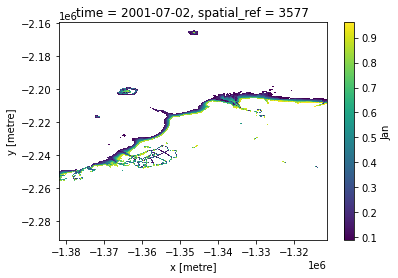

In [24]:
# (ITEMpolygons['0'])
# ds
ITEMpolygons['1']['Jan'].plot()

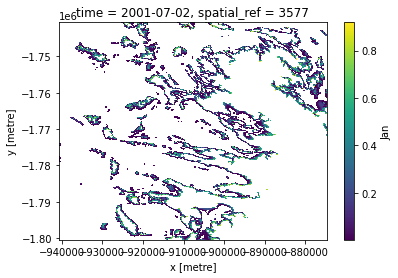

In [25]:
ITEMpolygons['1']['Jan'].plot()